# Colab Setup

In [ ]:
!nvidia-smi

Sat Jun 12 09:20:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install gdown --quiet

In [ ]:
!pip install scikit-plot --quiet

# Imports and Data Setup

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np  
import pandas as pd
from pathlib import Path
import scipy.io
import h5py

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.initializers import he_normal
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from scipy.signal import resample

from scipy.signal import find_peaks as findPeaks
from scipy import sparse
from scipy.sparse.linalg import spsolve

from pathlib import Path
import gdown

In [ ]:
datapath = Path('./data')

In [ ]:
# Download Raw Data
inertial_url = 'https://drive.google.com/uc?export=download&id=1gGd3nq889m9iU8gkyqk1YHLOqmR31VWb'
inertial_file = 'Inertial.zip'

skeleton_url = 'https://drive.google.com/uc?export=download&id=1rvnhTitWIWF-9biYyzzGXXcaY5BXecV1'
skeleton_file = 'Skeleton.zip'

gdown.download(inertial_url, inertial_file, quiet=True)
gdown.download(skeleton_url, skeleton_file, quiet=True)

'Skeleton.zip'

In [ ]:
!unzip -qq ./Inertial.zip -d ./data/

In [ ]:
!unzip -qq ./Skeleton.zip -d ./data/

# Process Dataset

## Process Inertia Data

In [ ]:
def import_data(file_type, action, subject, trial):
    filename = datapath/f'{file_type}/a{action}_s{subject}_t{trial}_{file_type.lower()}.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        if file_type.lower() == 'inertial':
            return mat['d_iner']
        else:
            return mat['d_skel']
    else:
        return None

In [ ]:
def calculate_angle(point1,point2,point3):


    point2_1 = point1 - point2
    point2_3 = point3 - point2

    cosine_angle = np.dot(point2_1, point2_3) / (np.linalg.norm(point2_1) * np.linalg.norm(point2_3))
    angle = np.arccos(cosine_angle)
    angle = np.degrees(angle)

    return angle

In [ ]:
# Importing Inertia Data 6 Features

def merge_inertial():

    i_trDat = []
    i_trLbl = []
    i_tsDat = []
    i_tsLbl = []

    index1 = 0
    index2 = 0
    counter = 0
    subject = 0
    for i in range (864):
        
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Inertial',action,subject,take)
        
        if data is not None:
                                          
            if subject == 2 or subject == 4 or subject == 6 or subject == 8:
                i_tsDat.append(resample(data, 180))
                i_tsLbl.append(action-1)
                index1 = index1 + 1 
            elif subject == 1 or subject == 3 or subject == 5 or subject == 7:
                i_trDat.append(resample(data, 180))
                i_trLbl.append(action-1)
                index2 = index2 + 1

    i_trDat = np.array(i_trDat)
    i_trLbl = np.array(i_trLbl)
    i_tsDat = np.array(i_tsDat)
    i_tsLbl = np.array(i_tsLbl)
                
    return i_trDat, i_trLbl, i_tsDat, i_tsLbl

i_trDat, i_trLbl, i_tsDat, i_tsLbl = merge_inertial()


i_trLbl = to_categorical(i_trLbl)
i_tsLbl = to_categorical(i_tsLbl)

print(i_trDat.shape)
print(i_trLbl.shape)
print(i_tsDat.shape)
print(i_tsLbl.shape)


(431, 180, 6)
(431, 27)
(430, 180, 6)
(430, 27)


## Process Skeleton Data

In [ ]:
def merge_skeleton():

    reshaped_data = np.zeros([861,116,60])
    sa_trDat = []
    trLbl = []
    sa_tsDat = []
    tsLbl = []
 
    index = 0
    counter = 0
    subject = 0

    for i in range (864):
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Skeleton',action,subject,take)
        
        if data is not None:
                        
            temp_array = np.zeros([data.shape[2],60])
            temp_array_angle = np.zeros([data.shape[2],16])
            for j in range (data.shape[2]):
                temp_array[j,:] = data[:,:,j].flatten()
                
                temp_array_angle[j,0]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,6:8])             #head_spine_angle
                temp_array_angle[j,1]= calculate_angle(temp_array[j,3:5],temp_array[j,6:8],temp_array[j,9:11])            #spine_angle
                temp_array_angle[j,2]= calculate_angle(temp_array[j,15:17],temp_array[j,18:20],temp_array[j,21:23])       #left_wrist_angle
                temp_array_angle[j,3]= calculate_angle(temp_array[j,13:14],temp_array[j,15:17],temp_array[j,18:20])       #left_elbow_angle
                temp_array_angle[j,4]= calculate_angle(temp_array[j,3:5],temp_array[j,12:14],temp_array[j,15:17])         #left_shoulder_angle
                temp_array_angle[j,5]= calculate_angle(temp_array[j,39:41],temp_array[j,42:44],temp_array[j,45:47])       #left_ankle_angle
                temp_array_angle[j,6]= calculate_angle(temp_array[j,36:38],temp_array[j,39:41],temp_array[j,42:44])       #left_knee_angle
                temp_array_angle[j,7]= calculate_angle(temp_array[j,9:11],temp_array[j,36:38],temp_array[j,39:41])        #left_hip_angle
                temp_array_angle[j,8]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,12:14])           #left_shoulder_head_angle
                temp_array_angle[j,9]= calculate_angle(temp_array[j,27:29],temp_array[j,30:32],temp_array[j,33:35])       #right_wrist_angle
                temp_array_angle[j,10]= calculate_angle(temp_array[j,24:26],temp_array[j,27:29],temp_array[j,30:32])      #right_elbow_angle
                temp_array_angle[j,11]= calculate_angle(temp_array[j,3:5],temp_array[j,24:26],temp_array[j,27:29])        #right_shoulder_angle
                temp_array_angle[j,12]= calculate_angle(temp_array[j,51:53],temp_array[j,54:56],temp_array[j,57:59])      #right_ankle_angle
                temp_array_angle[j,13]= calculate_angle(temp_array[j,48:50],temp_array[j,51:53],temp_array[j,54:56])      #right_knee_angle
                temp_array_angle[j,14]= calculate_angle(temp_array[j,9:11],temp_array[j,48:50],temp_array[j,51:53])       #right_hip_angle
                temp_array_angle[j,15]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,24:26])          #right_shoulder_head_angle

            
            if subject == 2 or subject == 4 or subject == 6 or subject == 8:
                
                sa_tsDat.append(resample(temp_array_angle,180))
                tsLbl.append(action-1)
               
            elif subject == 1 or subject == 3 or subject == 5 or subject == 7:

                sa_trDat.append(resample(temp_array_angle,180))
                trLbl.append(action-1)
       
                
            index = index + 1
   
    sa_trDat = np.array(sa_trDat)
    trLbl = np.array(trLbl)
    sa_tsDat = np.array(sa_tsDat)
    tsLbl = np.array(tsLbl)
 
    return sa_trDat, trLbl, sa_tsDat, tsLbl

sa_trDat, trLbl, sa_tsDat, tsLbl = merge_skeleton()

trLbl = to_categorical(trLbl)
tsLbl = to_categorical(tsLbl)

print(sa_trDat.shape)
print(trLbl.shape)
print(sa_tsDat.shape)
print(tsLbl.shape)


(431, 180, 16)
(431, 27)
(430, 180, 16)
(430, 27)


## Concatenate

In [ ]:
trDat = np.concatenate((sa_trDat, i_trDat), axis = -1)
tsDat = np.concatenate((sa_tsDat, i_tsDat), axis = -1)

print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 180, 22)
(431, 27)
(430, 180, 22)
(430, 27)


# Train ConvLSTM Model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

def conv_LSTM():
    np.random.seed(7)
    optimizer = Adam(lr=1e-4, decay=1e-6, clipnorm=0.6)
    model = Sequential(name = 'conv_LSTM')
    model.add(Conv1D(128,
                     4,
                     padding='valid',
                     activation='relu',
                     strides=1,
                    input_shape=(180,22)))
    model.add(Conv1D(64,
                     4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(Conv1D(64,
                     4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(Conv1D(64,
                     4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(len(list(range(1,28))), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    return model
    
LSTM = conv_LSTM()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "conv_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 177, 128)          11392     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 174, 64)           32832     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 171, 64)           16448     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 168, 64)           16448     
_________________________________________________________________
lstm (LSTM)                  (None, 168, 256)          328704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 168, 256)          525312    
_________________________________________________________________
flatten (Flatten)            (None, 43008)             0 

In [ ]:
baseline = LSTM.fit(trDat, trLbl, epochs=20, batch_size=4, validation_data = (tsDat, tsLbl))

Epoch 1/20
108/108 [==============================] - 155s 1s/step - loss: 2.7733 - accuracy: 0.2343 - val_loss: 1.5049 - val_accuracy: 0.5465
Epoch 2/20
108/108 [==============================] - 120s 1s/step - loss: 0.7375 - accuracy: 0.7889 - val_loss: 1.0228 - val_accuracy: 0.7047
Epoch 3/20
108/108 [==============================] - 121s 1s/step - loss: 0.2508 - accuracy: 0.9258 - val_loss: 1.0429 - val_accuracy: 0.7163
Epoch 4/20
108/108 [==============================] - 123s 1s/step - loss: 0.1102 - accuracy: 0.9675 - val_loss: 0.7096 - val_accuracy: 0.8047
Epoch 5/20
108/108 [==============================] - 120s 1s/step - loss: 0.0414 - accuracy: 0.9884 - val_loss: 0.8262 - val_accuracy: 0.7814
Epoch 6/20
108/108 [==============================] - 123s 1s/step - loss: 0.0233 - accuracy: 0.9930 - val_loss: 0.9223 - val_accuracy: 0.7837
Epoch 7/20
108/108 [==============================] - 123s 1s/step - loss: 0.0207 - accuracy: 0.9930 - val_loss: 1.0615 - val_accuracy: 0.7721

# Evaluate

In [ ]:
pred_1 = np.argmax(LSTM.predict(tsDat), axis = -1)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(np.argmax(tsLbl, axis = -1),pred_1))  
print(accuracy_score(np.argmax(tsLbl, axis = -1), pred_1)) 

              precision    recall  f1-score   support

           0       0.62      0.94      0.75        16
           1       1.00      0.69      0.81        16
           2       0.88      0.94      0.91        16
           3       0.62      0.81      0.70        16
           4       0.82      0.56      0.67        16
           5       0.76      1.00      0.86        16
           6       0.74      0.88      0.80        16
           7       0.75      0.94      0.83        16
           8       1.00      0.81      0.90        16
           9       0.67      0.75      0.71        16
          10       1.00      0.75      0.86        16
          11       0.88      0.94      0.91        16
          12       0.83      0.94      0.88        16
          13       0.94      1.00      0.97        16
          14       1.00      0.69      0.81        16
          15       1.00      1.00      1.00        16
          16       0.93      0.88      0.90        16
          17       0.79    

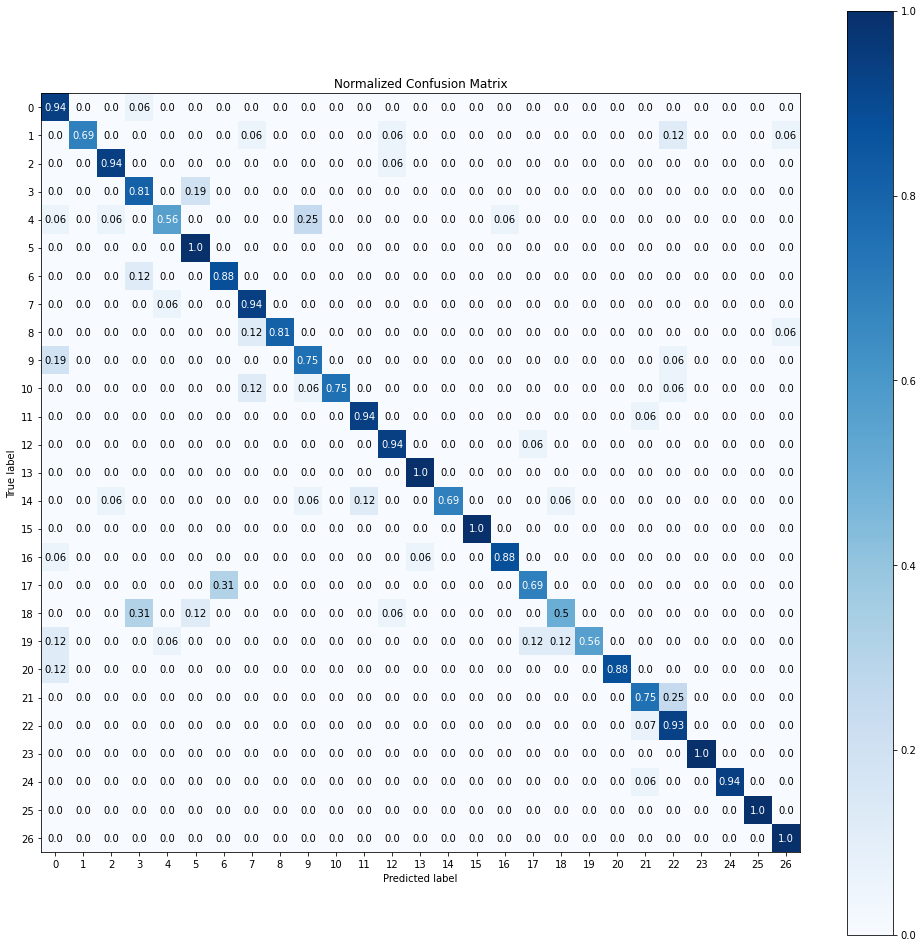

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(np.argmax(tsLbl, axis = -1), pred_1, normalize=True, figsize=(17,17))